In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from datetime import timedelta
from collections import defaultdict
%matplotlib inline

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        f = pd.read_csv(file_url)
        f['WEEK_NUM'] = week_num
        dfs.append(f)
    return pd.concat(dfs)

In [3]:
week_nums = ['170916', '170909', '170902', '170826', '170819', '170812',  '170805', '170729', '170722', '170715', '170708', '170701', '170624', '170617', '170610', '170603']
turnstiles_df = get_data(week_nums)


In [4]:
def my_datetime(s):
    return datetime.datetime.strptime(str(s) ,'%m/%d/%Y %H:%M:%S')

def my_other_datetime(s):
    return datetime.datetime.strptime(str(s) ,'%Y-%m-%d %H:%M:%S')

def my_weekday(dt): #
    '''returns friday for the saturday 00:00:00-04:00:00 window, etc.'''
    return (my_other_datetime(dt) + timedelta(hours = -4)).weekday()

def datetime_to_time(dt):
    return my_other_datetime(dt).time()

def midpoint_time(t):
    return my_other_datetime(t) + timedelta(hours = 2)

def is_valid(t):
    return (
        (t == '00:00:00')
        | (t == '04:00:00')
        | (t == '08:00:00')
        | (t == '12:00:00')
        | (t == '16:00:00')
        | (t == '20:00:00')
    )

In [5]:
def setup_frame(df):
    df['EXITS_CUM'] = df['EXITS                                                               ']
    df['ENTRIES_CUM'] = df['ENTRIES']
    del df['EXITS                                                               ']
    del df['ENTRIES']
    df['DATETIME'] =  df['DATE'] + ' ' + df['TIME']
    df['DATETIME'] = df['DATETIME'].apply(my_datetime)
    df = df[is_valid(df.TIME)]
    df['ENTRIES'] = df['ENTRIES_CUM'].shift(-1) - df['ENTRIES_CUM']
    df['EXITS'] = df['EXITS_CUM'].shift(-1) - df['EXITS_CUM']
    df['MIDPOINT'] = df['DATETIME'].apply(midpoint_time)
    df['DAY_OF_WEEK'] = df['MIDPOINT'].apply(my_weekday)
    df['TIME'] = df['MIDPOINT'].apply(datetime_to_time)
    df.ENTRIES[(df.ENTRIES < 0)] = np.nan
    df.ENTRIES[(df.ENTRIES > 10000)] = np.nan
    df.EXITS[(df.EXITS < 0)] = np.nan
    df.EXITS[(df.EXITS > 10000)] = np.nan
    df['TRAFFIC'] = (df.ENTRIES + df.EXITS) / 4
    return df

In [6]:
turnstiles_df = setup_frame(turnstiles_df)

/Users/home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [7]:
copy = turnstiles_df.copy(deep=True)

In [8]:
stations_gb = turnstiles_df.groupby(['STATION', 'MIDPOINT','DAY_OF_WEEK', 'TIME','WEEK_NUM']).sum().reset_index()
mean_by_week = stations_gb.groupby(['STATION','DAY_OF_WEEK', 'TIME']).mean().reset_index()[['STATION', 'DAY_OF_WEEK', 'TIME', 'TRAFFIC']]

In [9]:
nights = mean_by_week[(mean_by_week.TIME) == datetime.time(2)].set_index('STATION')
fri_nights = nights[nights.DAY_OF_WEEK == 4].sort_values('TRAFFIC', ascending=False)['TRAFFIC']
sat_nights = nights[nights.DAY_OF_WEEK == 5].sort_values('TRAFFIC', ascending=False)['TRAFFIC']

In [10]:
weeknights = nights[nights.DAY_OF_WEEK < 3]
weeknight_avg = weeknights.groupby(['STATION']).mean().reset_index()[['STATION', 'TRAFFIC']]
weeknights = weeknight_avg.set_index('STATION').sort_values('TRAFFIC', ascending=False)['TRAFFIC']

In [11]:
daily_total_traffic = mean_by_week.groupby(['STATION', 'DAY_OF_WEEK']).sum().reset_index().set_index('STATION')
fri_total = daily_total_traffic[daily_total_traffic.DAY_OF_WEEK == 4]['TRAFFIC'].sort_values(ascending=False)
sat_total = daily_total_traffic[daily_total_traffic.DAY_OF_WEEK == 5]['TRAFFIC'].sort_values(ascending=False)

In [12]:
weekdays_total_traffic = daily_total_traffic[daily_total_traffic.DAY_OF_WEEK < 3].groupby(['STATION']).mean()
weekdays_total_traffic.sort_values('TRAFFIC', ascending=False).head(10)
weekdays = weekdays_total_traffic.sort_values('TRAFFIC', ascending=False)['TRAFFIC']

In [13]:
weekdays_comparison = pd.merge(pd.DataFrame(weeknights), pd.DataFrame(weekdays), left_index=True, right_index=True)
weekdays_comparison.rename(columns={'TRAFFIC_x' : 'WEEKNIGHTS', 'TRAFFIC_y' : 'WEEKDAYS'}, inplace=True)
weekdays_comparison.head()
weekdays_comparison['WEEKDAY_RATIOS'] = weekdays_comparison['WEEKNIGHTS'] / weekdays_comparison['WEEKDAYS']

/Users/home/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

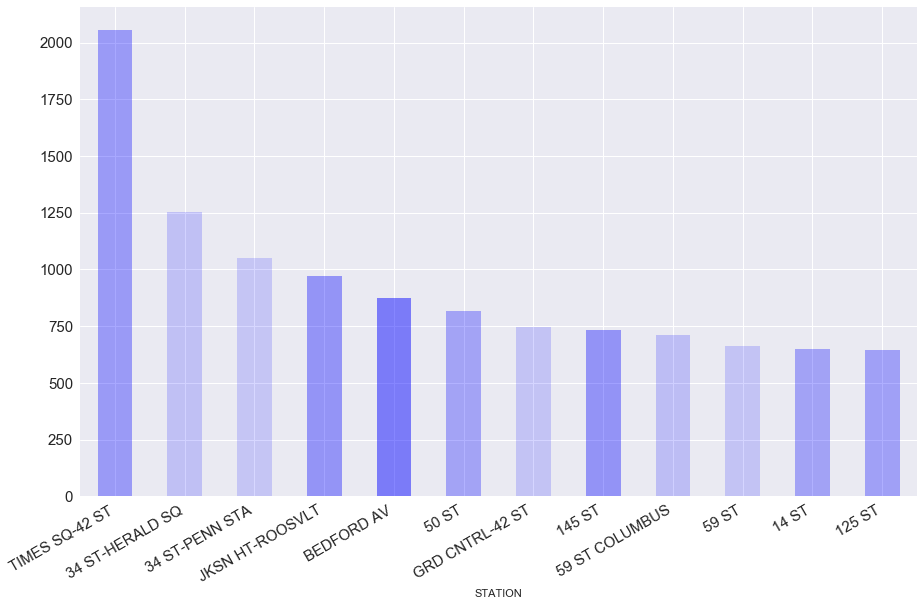

In [14]:
fri_comparison = pd.merge(pd.DataFrame(fri_nights), pd.DataFrame(fri_total), left_index=True, right_index=True)
fri_comparison = fri_comparison.rename(columns={'TRAFFIC_x' : 'FRI_NIGHT', 'TRAFFIC_y' : 'FRI_TOT'})
fri_comparison['RATIO'] = fri_comparison['FRI_NIGHT'] / fri_comparison['FRI_TOT']


fri_alphas = fri_comparison.RATIO.head(12)*7

fri_rgba_colors = np.zeros((12,4))
fri_rgba_colors[:,2] = 1.0
fri_rgba_colors[:, 3] = fri_alphas

fri_comparison.FRI_NIGHT.head(12).plot(kind='bar', colors=fri_rgba_colors, figsize=(15, 9), fontsize=15, rot = 30)
plt.xticks(ha='right')

/Users/home/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:178: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

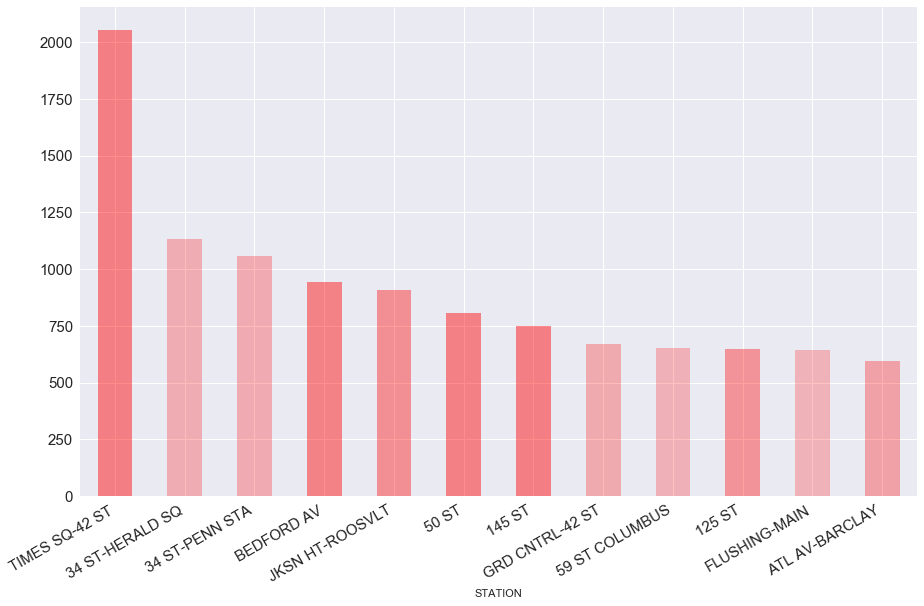

In [15]:
sat_comparison = pd.merge(pd.DataFrame(sat_nights), pd.DataFrame(sat_total), left_index=True, right_index=True)
sat_comparison = sat_comparison.rename(columns={'TRAFFIC_x' : 'SAT_NIGHT', 'TRAFFIC_y' : 'SAT_TOT'})
sat_comparison['RATIO'] = sat_comparison['SAT_NIGHT'] / sat_comparison['SAT_TOT']
sat_comparison.RATIO.describe()

sat_alphas = sat_comparison.RATIO.head(12)*7

sat_rgba_colors = np.zeros((12,4))
sat_rgba_colors[:,0] = 1.0
sat_rgba_colors[:, 3] = sat_alphas


sat_comparison.SAT_NIGHT.head(12).plot(kind='bar', colors=sat_rgba_colors, figsize=(15, 9), fontsize=15, rot = 30)
plt.xticks(ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

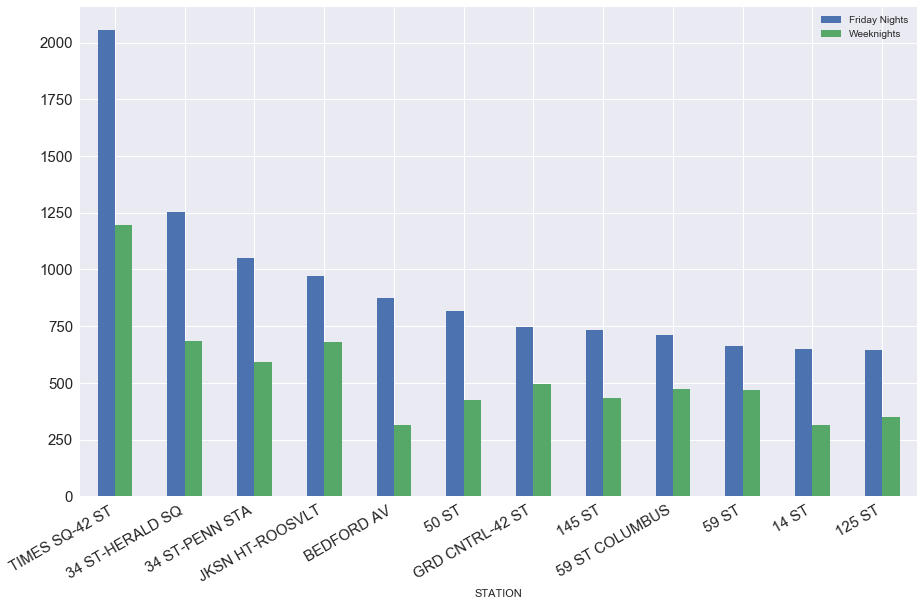

In [16]:
weekdays_fri_comp = pd.merge(fri_comparison, weekdays_comparison, left_index=True, right_index=True)
weekdays_fri_comp = weekdays_fri_comp.sort_values('FRI_NIGHT', ascending=False)
weekdays_fri_comp.rename(columns={'FRI_NIGHT' : 'Friday Nights', 'WEEKNIGHTS' : 'Weeknights'}, inplace=True)

weekdays_fri_comp[['Friday Nights', 'Weeknights']].head(12).plot(kind='bar', figsize =(15, 9), fontsize=15, rot = 30)
plt.xticks(ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

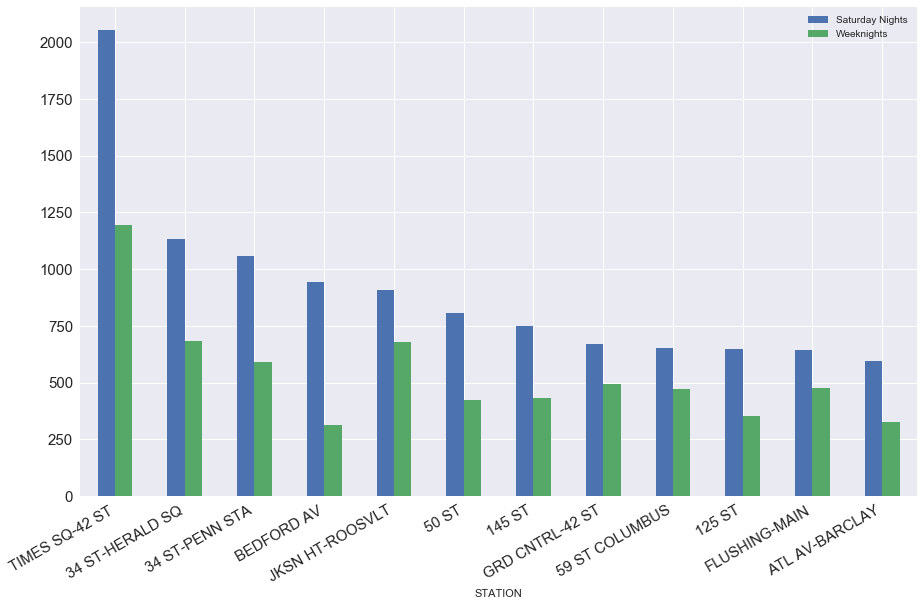

In [17]:
weekdays_sat_comp = pd.merge(sat_comparison, weekdays_comparison, left_index=True, right_index=True)
weekdays_sat_comp = weekdays_sat_comp.sort_values('SAT_NIGHT', ascending=False)
weekdays_sat_comp.rename(columns={'SAT_NIGHT' : 'Saturday Nights', 'WEEKNIGHTS' : 'Weeknights'}, inplace=True)

weekdays_sat_comp[['Saturday Nights', 'Weeknights']].head(12).plot(kind='bar', figsize =(15, 9), fontsize=15, rot = 30)
plt.xticks(ha='right')

In [18]:
precincts = pd.DataFrame()
precincts['STATION'] =['9TH STREET','TIMES SQ-42 ST', '34 ST-PENN STA', 'BEDFORD AV', '34 ST-HERALD SQ', '14 ST-UNION SQ', '50 ST', 'JKSN HT-ROOSVLT', 'W 4 ST-WASH SQ', '1 AV', '145 ST', '59 ST COLUMBUS', 'GRD CNTRL-42 ST', '59 ST']
precincts['PRECINCT'] =[6, 14, 14, 94, 14, 13, 18, 110, 6, 13, 30, 18, 14, 72]
precincts['CRIME'] = [123, 183, 183, 75, 183, 132, 177, 116, 123, 132, 53, 177, 183, 84]

In [19]:
top_10_sat = pd.DataFrame(fri_nights.head(10)).reset_index()
precincts_sat = precincts.merge(top_10_sat, left_on='STATION', right_on='STATION', how='inner').sort_values('TRAFFIC', ascending=False).reset_index()[['STATION', 'PRECINCT', 'CRIME', 'TRAFFIC']]

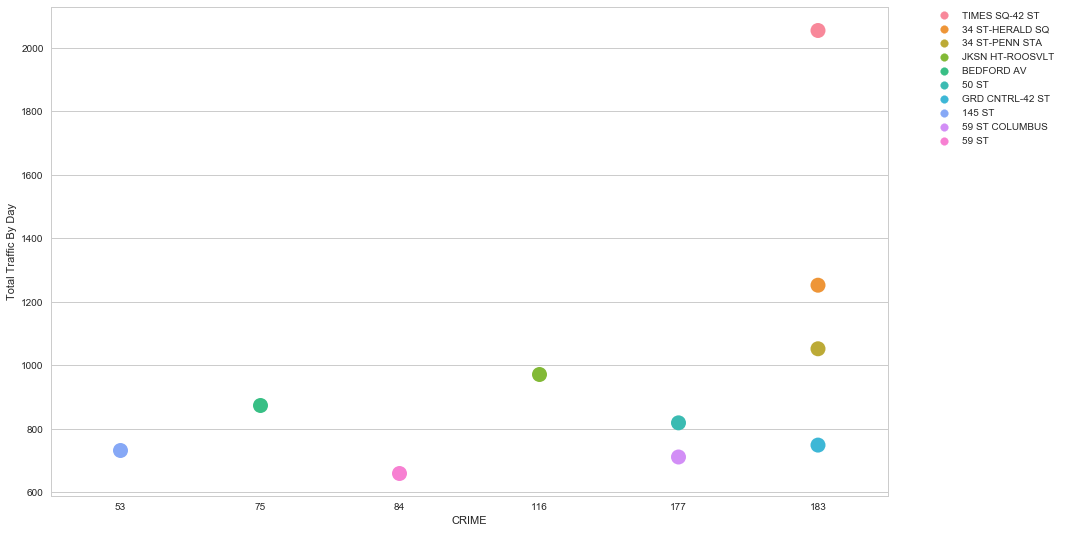

In [25]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(15,9))
g = sns.swarmplot(x="CRIME", y="TRAFFIC", hue="STATION", data=precincts_sat, size=15)
#ax.set_title('CRIME VS TOTAL TRAFFIC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Total Traffic By Day')